In [2]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import urllib
import numpy as np
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
#download film permit data
!curl -O https://data.cityofnewyork.us/api/views/tg4x-b46p/rows.csv?accessType=DOWNLOAD
!mv rows.csv?accessType=DOWNLOAD nycfilmpermits.csv
!mv nycfilmpermits.csv $PUIDATA

In [25]:
#download street shapefile
url = 'https://data.cityofnewyork.us/api/geospatial/exjm-f27b?method=export&format=Shapefile'
urllib.request.urlretrieve(url, "NYCstreets.zip")
!mv NYCstreets.zip $PUIDATA
!unzip $PUIDATA/NYCstreets.zip -d $PUIDATA/NYCstreets

Archive:  /nfshome/ak3940/PUIdata/NYCstreets.zip
  inflating: /nfshome/ak3940/PUIdata/NYCstreets/geo_export_35b06aaa-0db5-4e06-9e91-2b27da130de3.dbf  
  inflating: /nfshome/ak3940/PUIdata/NYCstreets/geo_export_35b06aaa-0db5-4e06-9e91-2b27da130de3.shp  
  inflating: /nfshome/ak3940/PUIdata/NYCstreets/geo_export_35b06aaa-0db5-4e06-9e91-2b27da130de3.shx  
  inflating: /nfshome/ak3940/PUIdata/NYCstreets/geo_export_35b06aaa-0db5-4e06-9e91-2b27da130de3.prj  


In [ ]:
#download zipcode shapefile
!curl -O https://data.cityofnewyork.us/api/views/i8iw-xf4u/files/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip
!mv YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip $PUIDATA
!unzip $PUIDATA/YObIR0MbpUVA0EpQzZSq5x55FzKGM2ejSeahdvjqR20?filename=ZIP_CODE_040114.zip -d $PUIDATA

In [5]:
data = pd.read_csv('~/PUIdata/nycfilmpermits.csv')

data = data[data['EventType'] == 'Shooting Permit'] #filter shooting permits
data = data.rename(columns={'ZipCode(s)': 'ZipCode', 'SubCategoryName': 'SubCategory', 'ParkingHeld': 'Location'})
data = data.drop(['EventAgency', 'EventType', 'EnteredOn', 'CommunityBoard(s)', 'PolicePrecinct(s)'], axis=1)

#fix naming inconsistencies of streets/avenues
data['Location'] = data['Location'].str.upper()
data['Location'] = data['Location'].str.replace('AVENUE', 'AVE')
data['Location'] = data['Location'].str.replace('STREET', 'ST')

pat = ['1ST', '2ND', '3RD', '4TH', '5TH', '6TH', '7TH', '8TH', '9TH', '0TH', '11TH', '12TH', '13TH']
repl = list(map(str, range(1,14)))

for i in range(12):
    data['Location'] = data['Location'].str.replace(pat[i], repl[i])

data.head()

,EventID,StartDateTime,EndDateTime,Location,Borough,Category,SubCategory,Country,ZipCode
0,300134,07/18/2016 06:00:00 AM,07/18/2016 12:00:00 PM,COLUMBUS AVE BETWEEN WEST 67 ST AND WEST 6...,Manhattan,Television,Morning Show,United States of America,10023
1,299797,07/18/2016 07:00:00 AM,07/18/2016 07:00:00 PM,"22 ST BETWEEN QUEENS PLAZA SOUTH AND 43 AVE, ...",Queens,Television,Cable-episodic,United States of America,11101
2,300179,07/18/2016 07:00:00 AM,07/18/2016 10:00:00 PM,MONITOR ST BETWEEN NORMAN AVE AND GREENPOINT A...,Queens,Television,Episodic series,United States of America,"11101, 11222, 11378"
3,300630,07/18/2016 12:00:00 PM,07/18/2016 09:00:00 PM,ROCKAWAY BEACH BOULEVARD BETWEEN BEACH 69 ST...,Queens,Commercial,Commercial,United States of America,11692
4,300127,07/18/2016 06:00:00 AM,07/18/2016 11:59:00 PM,"10 AVE BETWEEN WEST 26 ST AND WEST 27 ST, ...",Manhattan,Television,Reality,United States of America,10001


In [6]:
streetData = data[['EventID', 'Location', 'Borough']]

streetData['Location'] = streetData['Location'].str.split(',') #split streets to list

def unnest(df, col):
    unnested = (df.apply(lambda x: pd.Series(x[col]), axis=1)
                .stack()
                .reset_index(level=1, drop=True))
    unnested.name = col
    return df.drop(col, axis=1).join(unnested)

streetData = unnest(streetData, 'Location')

streetData[['Street', 'Between', 'CrossStreets']] = streetData['Location'].str.partition(' BETWEEN')
streetData[['CrossStreet1', 'And', 'CrossStreet2']] = streetData['CrossStreets'].str.partition(' AND')
streetData = streetData.drop(['Location', 'Between', 'CrossStreets', 'And'], axis = 1)
streetData.head(20)

,EventID,Borough,Street,CrossStreet1,CrossStreet2
0,300134,Manhattan,COLUMBUS AVE,WEST 67 ST,WEST 66 ST
1,299797,Queens,22 ST,QUEENS PLAZA SOUTH,43 AVE
1,299797,Queens,21 ST,QUEENS PLAZA SOUTH,43 AVE
1,299797,Queens,QUEENS PLAZA SOUTH,21 ST,22 ST
1,299797,Queens,QUEENS PLAZA SOUTH,21 ST,22 ST
2,300179,Queens,MONITOR ST,NORMAN AVE,GREENPOINT AVE
2,300179,Queens,KINGSLAND AVE,GREENPOINT AVE,NORMAN AVE
2,300179,Queens,GREENPOINT AVE,STARR AVE,BRADLEY AVE
2,300179,Queens,LAUREL HILL BOULEVARD,56 ROAD,54 AVE
2,300179,Queens,GREENPOINT AVE,GALE AVE,BORDEN AVE


In [7]:
streetCounts = pd.DataFrame(streetData.groupby(['Borough', 'Street'])['EventID'].count())
streetCounts = streetCounts.reset_index()
streetCounts = streetCounts.rename(columns={'EventID': 'Events'})
streetCounts.head()

,Borough,Street,Events
0,Bronx,1 AVE,2
1,Bronx,10 AVE,1
2,Bronx,10 ST,1
3,Bronx,11 AVE,1
4,Bronx,11 ST,1


In [8]:
streets = gpd.GeoDataFrame.from_file('/nfshome/ak3940/PUIdata/NYCstreets/geo_export_35b06aaa-0db5-4e06-9e91-2b27da130de3.shp')
streets = streets[['full_stree', 'borocode', 'geometry']]
streets = streets.rename(columns={'full_stree': 'Street', 'borocode': 'Borough'})
streets = streets[streets['Borough'].astype(int) < 6]

streets['Borough'] = streets['Borough'].replace({'1': 'Manhattan',
                                                '2': 'Bronx',
                                                '3': 'Brooklyn',
                                                '4': 'Queens',
                                                '5': 'Staten Island'})

streets = streets.merge(streetCounts, on = ['Borough', 'Street'], how = 'left')
streets['Events'] = streets['Events'].fillna(0).astype(int)
filmed = streets[streets['Events'] != 0]
notfilmed = streets[streets['Events'] == 0]

In [9]:
filmed['EventsNorm'] = (filmed['Events'] - filmed['Events'].min()) / (filmed['Events'].max() - filmed['Events'].min()) + 1
filmed.head()

,Street,Borough,geometry,Events,EventsNorm
1,28 AVE,Queens,LINESTRING (-73.7729030190404 40.7778042809822...,5,1.003976
2,SCHERMERHORN ST,Brooklyn,LINESTRING (-73.98181677514282 40.687329801759...,59,1.057654
3,QUEENS BLVD,Queens,LINESTRING (-73.8300230194527 40.7140059978106...,24,1.022863
4,ARLINGTON AVE,Bronx,LINESTRING (-73.90711253281893 40.905186250792...,1,1.000000
8,FOREST AVE,Queens,LINESTRING (-73.90098639497059 40.702449447994...,2,1.000994


/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/matplotlib/font_manager.py:1316: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


(-74.282703265402276,
 -73.672273392634366,
 40.477016748016119,
 40.935964451872472)

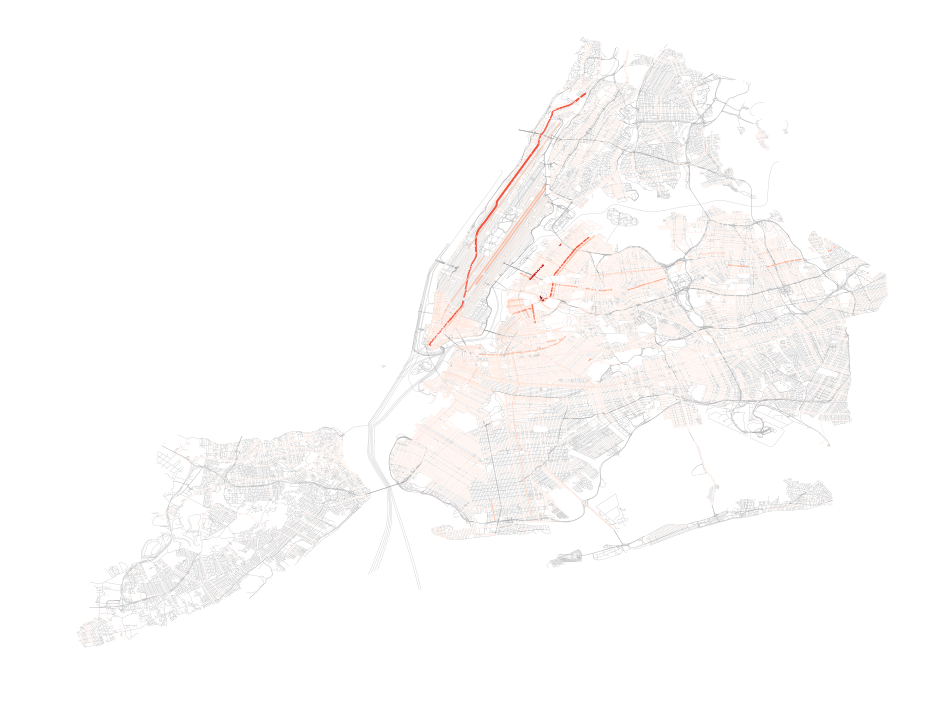

In [135]:
base = notfilmed.plot(figsize=(16,16), color='grey', lw = .2, alpha = .7)
filmed.plot(ax = base, figsize=(16,16), column='EventsNorm', cmap='Reds', lw = filmed.EventsNorm)
plt.axis('off')
plt.show()

In [10]:
zipData = data[['EventID', 'Category', 'SubCategory', 'ZipCode']]
zipData['ZipCode'] = zipData['ZipCode'].str.split(',') #split zipcodes to list
zipData = unnest(zipData, 'ZipCode')
zipData.head()

,EventID,Category,SubCategory,ZipCode
0,300134,Television,Morning Show,10023
1,299797,Television,Cable-episodic,11101
2,300179,Television,Episodic series,11101
2,300179,Television,Episodic series,11222
2,300179,Television,Episodic series,11378


In [11]:
zipCounts = pd.DataFrame(zipData.groupby(['ZipCode', 'Category'])['EventID'].count())
zipCounts = zipCounts.rename(columns={'EventID': 'Events'})
zipCounts = zipCounts.reset_index()

zips = gpd.GeoDataFrame.from_file('/nfshome/ak3940/PUIdata/ZIP_CODE_040114.shp')
zips = zips.rename(columns={'ZIPCODE': 'ZipCode'})
zips = zips[['ZipCode', 'geometry']]
zips = zips.merge(zipCounts, on = 'ZipCode', how = 'left')
zips['Events'] = zips['Events'].fillna(0)
zips['Events'] = zips['Events'].astype(int)
zips.head()

,ZipCode,geometry,Category,Events
0,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",Television,1
1,11436,"POLYGON ((1038098.251871482 188138.3800067157,...",WEB,2
2,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",Commercial,6
3,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",Film,30
4,11213,"POLYGON ((1001613.712964058 186926.4395172149,...",Still Photography,2


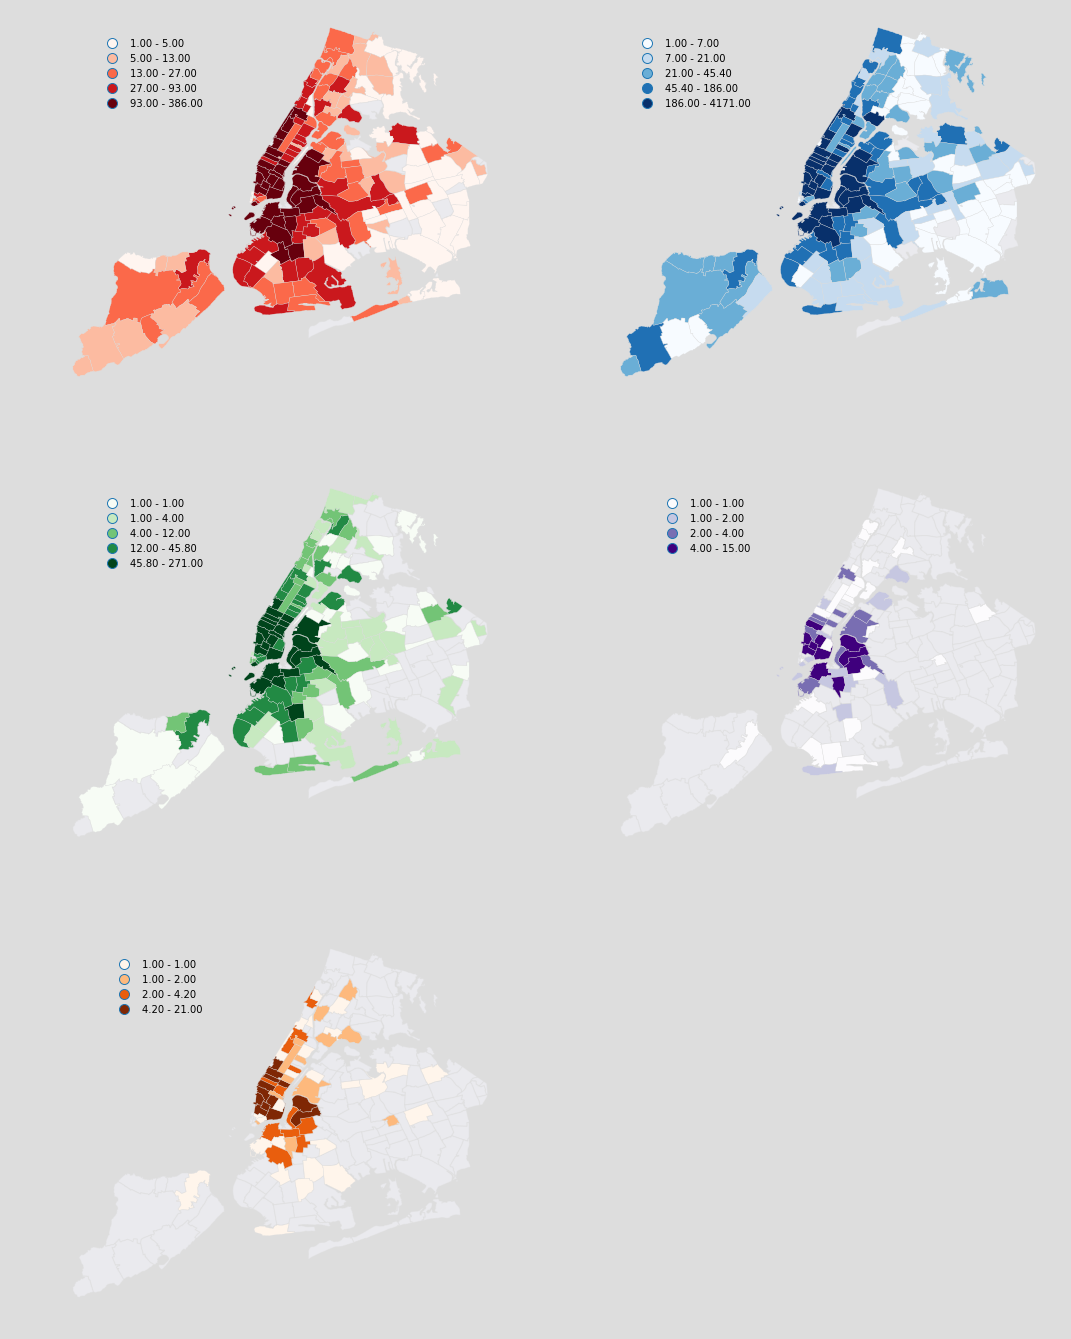

In [86]:
base = gpd.GeoDataFrame.from_file('/nfshome/ak3940/PUIdata/ZIP_CODE_040114.shp')


fig, axes = plt.subplots(nrows=3, ncols=2, figsize = (18,24), facecolor='#dddddd')

base.plot(ax = axes[0,0], color = 'ghostwhite', edgecolor = '#dddddd', alpha = 0.5)
zips[zips['Category'] == 'Film'].plot(ax = axes[0,0], column = 'Events', cmap='Reds', edgecolor='#dddddd', linewidth = 0.3, scheme='quantiles', legend = True)
axes[0,0].axis('off')
axes[0,0].get_legend().set_bbox_to_anchor((0.35, 0.95, 0, 0))
axes[0,0].get_legend().set_frame_on(False)

base.plot(ax = axes[0,1], color = 'ghostwhite', edgecolor = '#dddddd', alpha = 0.5)
zips[zips['Category'] == 'Television'].plot(ax = axes[0,1], column = 'Events', cmap='Blues', edgecolor='#dddddd', linewidth = 0.3, scheme='quantiles', legend = True)
axes[0,1].axis('off')
axes[0,1].get_legend().set_bbox_to_anchor((0.35, 0.95, 0, 0))
axes[0,1].get_legend().set_frame_on(False)

base.plot(ax = axes[1,0], color = 'ghostwhite', edgecolor = '#dddddd', alpha = 0.5)
zips[zips['Category'] == 'Commercial'].plot(ax = axes[1,0],column = 'Events', cmap='Greens', edgecolor='#dddddd', linewidth = 0.3, scheme='quantiles', legend = True)
axes[1,0].axis('off')
axes[1,0].get_legend().set_bbox_to_anchor((0.35, 0.95, 0, 0))
axes[1,0].get_legend().set_frame_on(False)

base.plot(ax = axes[1,1], color = 'ghostwhite', edgecolor = '#dddddd', alpha = 0.5)
zips[zips['Category'] == 'Music Video'].plot(ax = axes[1,1],column = 'Events', cmap='Purples', edgecolor='#dddddd', linewidth = 0.3, scheme='quantiles', legend = True)
axes[1,1].axis('off')
axes[1,1].get_legend().set_bbox_to_anchor((0.35, 0.95, 0, 0))
axes[1,1].get_legend().set_frame_on(False)

base.plot(ax = axes[2,0], color = 'ghostwhite', edgecolor = '#dddddd', alpha = 0.5)
zips[zips['Category'] == 'Documentary'].plot(ax = axes[2,0],column = 'Events', cmap='Oranges', edgecolor='#dddddd', linewidth = 0.3, scheme='quantiles', legend = True)
axes[2,0].axis('off')
axes[2,0].get_legend().set_bbox_to_anchor((0.35, 0.95, 0, 0))
axes[2,0].get_legend().set_frame_on(False)

axes[2,1].axis('off')

plt.show()

In [85]:
plt.savefig('NYCfilmlocations_revised.png', dpi=300, facecolor='#dddddd', edgecolor='#dddddd')